<img src="Q/ex4.4.png">
<img src="Q/ex4.4.1.png">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
from scipy import interpolate

plt.rcParams.update({'font.size': 14})

from utilities import error, convert1D_to_2D, plot_phi,matrixA,convert2D_to_1D

from utilities import GS,smoothing, restriction, residual,prolongation

In [2]:
def prepare_phi_and_S(Nx, Ny, phi, L, H, convert_to_K=False):
    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    if convert_to_K:
        S = np.zeros((Nx * Ny))
        phi = np.zeros((Nx * Ny))
    else:
        S = np.zeros((Nx, Ny))
        phi = np.zeros((Nx, Ny))
    dx = L / (Nx - 1)  # Grid size
    dy = H / (Ny - 1)  # Grid size
    # RHS source terms
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy

            source = 50000*np.exp(-50*((1-x)**2+y**2))*(100*((1-x)**2+y**2)-2)

            if convert_to_K:
                k = (j - 1) * Nx + i
                S[k] = source
            else:
                S[i, j] = source

    ## Right BC
    i = Nx - 1
    for j in range(1, Ny - 1):

        x = i * dx
        y = j * dy
        phiR = 100*(1-y) + 500*np.exp(-50*y**2)

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i, j] = phiR
            S[i, j] = phiR

    ## left BC
    i = 0
    for j in range(1, Ny - 1):

        x = i * dx
        y = j * dy

        phiL = 500*np.exp(-50*(1+y**2))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i, j] = phiL
            S[i, j] = phiL

    ## Bottom BC
    j = 0
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiB = 100*x + 500*np.exp(-50*(1-x)**2)
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i, j] = phiB
            S[i, j] = phiB

    ## Top BC
    j = Ny - 1
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiT = 500*np.exp(-50*((1-x)**2+1))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i, j] = phiT
            S[i, j] = phiT

    return phi, S

In [3]:
# The name of variable ends with c and f are corse and fine mesh
start = time.time()
Nx1 = 81
Ny1 = 81
Nx2 = 41
Ny2 = 41
Nx3 = 11
Ny3 = 11
L = 1  # length
H = 1  # length

phi1 = np.zeros((Nx1, Ny1))
phi2 = np.zeros((Nx2, Ny2))
phi3 = np.zeros((Nx3, Ny3))

dx1 = L / (Nx1 - 1)  # Grid size
dy1 = L / (Ny1 - 1)  # Grid size
x1_list = np.arange(0, 1 + dx1, dx1)
y1_list = np.arange(0, 1 + dy1, dy1)
x1, y1 = np.meshgrid(x1_list, y1_list, indexing='ij')

dx2 = L / (Nx2 - 1)  # Grid size
dy2 = L / (Ny2 - 1)  # Grid size
x2_list = np.arange(0, 1 + dx2, dx2)
y2_list = np.arange(0, 1 + dy2, dy2)
x2, y2 = np.meshgrid(x2_list, y2_list, indexing='ij')

dx3 = L / (Nx3 - 1)  # Grid size
dy3 = L / (Ny3 - 1)  # Grid size
x3_list = np.arange(0, 1 + dx3, dx3)
y3_list = np.arange(0, 1 + dy3, dy3)
x3, y3 = np.meshgrid(x3_list, y3_list, indexing='ij')

tolf = 1e-6
tolc = 1e-1

aE1 = 1 / dx1 ** 2
aW1 = 1 / dx1 ** 2
aN1 = 1 / dy1 ** 2
aS1 = 1 / dy1 ** 2
a01 = -(2 / dx1 ** 2 + 2 / dy1 ** 2)

aE2 = 1 / dx2 ** 2
aW2 = 1 / dx2 ** 2
aN2 = 1 / dy2 ** 2
aS2 = 1 / dy2 ** 2
a02 = -(2 / dx2 ** 2 + 2 / dy2 ** 2)
A2 = matrixA(Nx2,Ny2,dx2,dy2)

aE3 = 1 / dx3 ** 2
aW3 = 1 / dx3 ** 2
aN3 = 1 / dy3 ** 2
aS3 = 1 / dy3 ** 2
a03 = -(2 / dx3 ** 2 + 2 / dy3 ** 2)
A3 = matrixA(Nx3,Ny3,dx3,dy3)




In [4]:
def run(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01,Nx2, Ny2, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list, multi_sweep):
    Rlogger=[]
    for l in tqdm(range(10000)):
        # Smoothing
        R2_1, R_1_new = smoothing(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01)

        # Resitriction on 2nd grid
        phi2, R2_2, R_2_new = restriction(Nx2, Ny2, R_1_new, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list,multi_sweep=multi_sweep)

        # # Resitriction on 3rd grid
        # phi3, R2_3, R_3_new = restriction(Nx3, Ny3, R_2_new, aE3, aW3, aE3, aS3, a03, x2_list, y2_list, x3_list, y3_list,multi_sweep=None)

        # phi2 = prolongation(x3_list, y3_list, phi3, x2_list, y2_list, phi2)

        phi1 = prolongation(x2_list, y2_list, phi2, x1_list, y1_list, phi1)

        Rlogger.append(R2_1)
        if l % 20 == 0:
            clear_output(True)
            print('Residual on Fine mesh:', R2_1, 'Residual on Coarse mesh:', R2_2)

        if R2_1 < tolf:
            print('Converged! Residual: ', R2_1, 'Time elapsed: ', time.time() - start)
            break
    return Rlogger,l,phi1

In [11]:
phi1, S1 = prepare_phi_and_S(Nx1, Ny1, phi1, L, H)
t = time.time()
logger1,l1,phif = run(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01,Nx2, Ny2, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list, multi_sweep=None)
t1 = time.time() - t

phi1, S1 = prepare_phi_and_S(Nx1, Ny1, phi1, L, H)
t = time.time()
logger2,l2,_ = run(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01,Nx2, Ny2, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list, multi_sweep=2)
t2 = time.time() - t

phi1, S1 = prepare_phi_and_S(Nx1, Ny1, phi1, L, H)
t = time.time()
logger3,l3,_ = run(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01,Nx2, Ny2, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list, multi_sweep=3)
t3 = time.time() - t

phi1, S1 = prepare_phi_and_S(Nx1, Ny1, phi1, L, H)
t = time.time()
logger4,l4,_ = run(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01,Nx2, Ny2, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list, multi_sweep=4)
t4 = time.time() - t

phi1, S1 = prepare_phi_and_S(Nx1, Ny1, phi1, L, H)
t = time.time()
logger5,l5,_ = run(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01,Nx2, Ny2, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list, multi_sweep=5)
t5 = time.time() - t

print(f'1 sweep at restriction| Iteration: {l1} | Time elapsed: {t1}')
print(f'2 sweep at restriction| Iteration: {l2} | Time elapsed: {t2}')
print(f'3 sweep at restriction| Iteration: {l3} | Time elapsed: {t3}')
print(f'4 sweep at restriction| Iteration: {l4} | Time elapsed: {t5}')
print(f'5 sweep at restriction| Iteration: {l5} | Time elapsed: {t4}')

 31%|███▏      | 3141/10000 [01:06<02:26, 46.94it/s]

Residual on Fine mesh: 1.0013678386711636e-06 Residual on Coarse mesh: 4.974388896061657e-07
Converged! Residual:  9.937857017959505e-07 Time elapsed:  1646.8027670383453
1 sweep at restriction| Iteration: 3141 | Time elapsed: 66.92025113105774
2 sweep at restriction| Iteration: 1745 | Time elapsed: 39.949716091156006
3 sweep at restriction| Iteration: 1208 | Time elapsed: 29.45012593269348
4 sweep at restriction| Iteration: 924 | Time elapsed: 20.74908709526062
5 sweep at restriction| Iteration: 748 | Time elapsed: 24.069836854934692


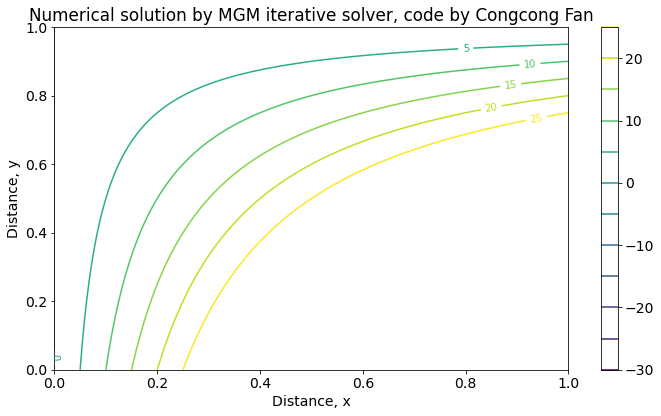

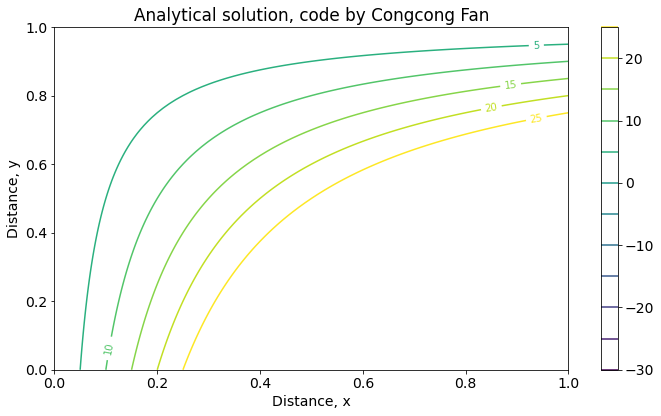

In [14]:

# Analytical solution
x = np.linspace(0,1,Nx1)
y = np.linspace(0,1,Ny1)
phi_A = np.zeros((Nx1,Ny1))
for i in range(Nx1):
    for j in range(Ny1):
        
        phi_A[i,j] = 500*np.exp(-50*((1-x[i])**2+y[j]**2)) + 100*x[i]*(1-y[j])

plot_phi(phif, phi_A, Nx1, Ny1, 'MGM', convert=False)


Text(0, 0.5, 'Residual')

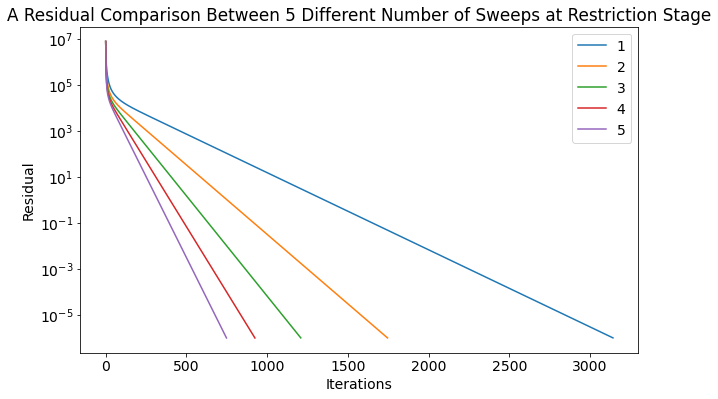

In [15]:
plt.figure(figsize = (10, 6))
plt.plot(logger1,label='1')
plt.plot(logger2,label='2')
plt.plot(logger3,label='3')
plt.plot(logger4,label='4')
plt.plot(logger5,label='5')
plt.yscale('log')
plt.legend()
plt.title('A Residual Comparison Between 5 Different Number of Sweeps at Restriction Stage')
plt.xlabel('Iterations')
plt.ylabel('Residual')

# With direct solver at restriction stage

In [16]:
def restriction_direct_soln(Nx, Ny, R1, aEc, aWc, aNc, aSc, a0c, x_list1, y_list1, x_list2, y_list2,A):

    # Transfer Residual to coarse mesh
    f = interpolate.RectBivariateSpline(x_list1, y_list1, R1)
    R2 = f(x_list2, y_list2)
    R2 = convert2D_to_1D(R2,Nx,Ny)
    # Smoothing the errors on the coarse mesh
    # Use the correction form [A][𝜙'] = [R] to calculate the correction form of phi
    phi_corrector = np.zeros((Nx, Ny))



    
    phi_corrector = np.linalg.inv(A)@R2
    R2c, _, R = residual(Nx, Ny, phi_corrector, R2, aEc, aWc, aNc, aSc, a0c, convert=True)
    R = convert1D_to_2D(R,Nx,Ny)
    phi_corrector = convert1D_to_2D(phi_corrector,Nx,Ny)
    return phi_corrector,R2c, R

In [17]:
# def run_direction_soln(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01,Nx2, Ny2, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list, A):
Rlogger=[]
for l in tqdm(range(10000)):
    # Smoothing
    R2_1, R_1_new = smoothing(Nx1, Ny1, phi1, S1, aE1, aW1, aN1, aS1, a01)

    # Resitriction on 2nd grid
    phi2, R2_2, R_2_new = restriction_direct_soln(Nx2, Ny2, R_1_new, aE2, aW2, aN2, aS2, a02, x1_list, y1_list, x2_list, y2_list,A2)

    # # Resitriction on 3rd grid
    # phi3, R2_3, R_3_new = restriction(Nx3, Ny3, R_2_new, aE3, aW3, aE3, aS3, a03, x2_list, y2_list, x3_list, y3_list,multi_sweep=None)

    # phi2 = prolongation(x3_list, y3_list, phi3, x2_list, y2_list, phi2)

    phi1 = prolongation(x2_list, y2_list, phi2, x1_list, y1_list, phi1)

    Rlogger.append(R2_1)
    if l % 20 == 0:
        clear_output(True)
        print('Residual on Fine mesh:', R2_1, 'Residual on Coarse mesh:', R2_2)

    if R2_1 < tolf:
        print('Converged! Residual: ', R2_1, 'Time elapsed: ', time.time() - start)
        break
    # return Rlogger

  0%|          | 22/10000 [00:02<21:25,  7.76it/s]

Residual on Fine mesh: 0.010113842555607646 Residual on Coarse mesh: 3.658990418967378e-17


  0%|          | 31/10000 [00:04<21:38,  7.68it/s]

Converged! Residual:  9.625623567776918e-07 Time elapsed:  1653.0230419635773


Text(0, 0.5, 'Residual')

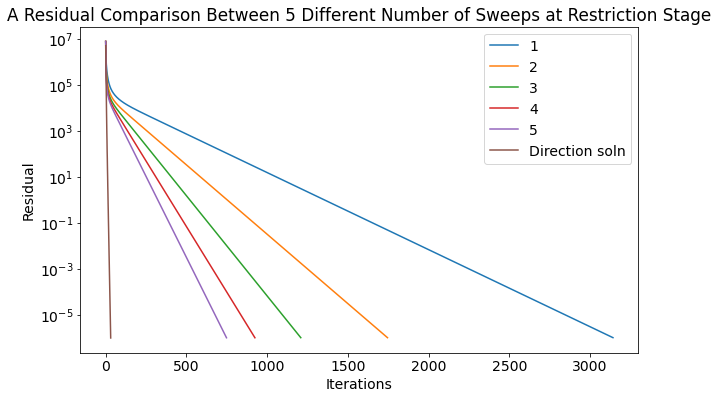

In [18]:
plt.figure(figsize = (10, 6))
plt.plot(logger1,label='1')
plt.plot(logger2,label='2')
plt.plot(logger3,label='3')
plt.plot(logger4,label='4')
plt.plot(logger5,label='5')
plt.plot(Rlogger,label='Direction soln')
plt.yscale('log')
plt.legend()
plt.title('A Residual Comparison Between 5 Different Number of Sweeps at Restriction Stage')
plt.xlabel('Iterations')
plt.ylabel('Residual')